# Table of Contents
* [Introduction: Generating and Decoding Dual Tone Multiple Frequency (DTMF) Signals](#part0)
* [Setup](#setup)
* [Part 1: Signal and Audio File Generation](#part1)
* [Part 2: Filter Design](#part2)
* [Part 3: Determine the dialed Sequence for a given WAV Audio File (Python 3)](#part3)
* [**Part 4: Determine the dialed Sequence for a given WAV Audio File (CUDA/C/C++)**](#part4)
* [Miscellaneous](#misc)

## Introduction: Generating and Decoding Dual Tone Multiple Frequency (DTMF) Signals <a class="anchor" id="part0"></a>
Dual-tone multi-frequency signaling (DTMF) is a signaling system for dialing a telephone which was developed in the early 1960s by Western Electric and later commerically supplied to telephone customers by Bell System.
When a key on the phone is pressed, two harmonic sound signals are generated and the superposition of both signals is used to characterize the phone key. For example, when the key "5" is pressed, a dual-tone signal composed of the frequencies 770 Hz and 1336 Hz is created. The two frequencies describing each key are listed in the following table:

|   | 1209Hz  | 1336 Hz  | 1477 Hz   | 1633 Hz  |
|---|:---:|:---:|:---:|:---:|
| **697 Hz**  |  1 | 2  | 3  | A  |
| **770 Hz**  |  4 | 5  | 6  | B  |
| **852 Hz**  |  7 | 8  | 9  | C  |
| **941 Hz**  |  * | 0  | #  | D  |

In this GitHub example, we will look at how to generate such DTMF dialing sequences, save them into an audio file and decode the audio signal again using simple FIR bandpass filters.
**A special focus will be on a CUDA/C/C++ implementation of the Python3 example below. You can find the commented source code in the file `dtmfCuda.cu`.**

We will perform the following steps to generate and decode a DTMF signal:
1. Signal and audio file generation using `scipy` and `numpy`. We save the generated audio in a `.wav` file which can be played in this notebook or in your local audio player
2. We design a simple filter bank consisting of 8 bandpass filters which each only let one of the DTMF frequencies pass
3. Extraction of the dialed key sequence from the `.wav` file using the filter bank and several post-processing steps

## Setup <a class="anchor" id="setup"></a>

### Cloning this Repository

You can clone this Git repository via HTTPS:

`git clone https://github.com/MarkusThill/DTMFCuda.git`

or via SSH:

`git clone git@github.com:MarkusThill/DTMFCuda.git`

The code presented in this Readme file below can also be executed in a Jupyter Notebook environment (e.g. in Google Colab) using the file `dtmf_example.ipynb` notebook.

### Running the Jupyter Notebook in Google Colab
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MarkusThill/DTMFCuda/blob/main/dtmf_example.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MarkusThill/DTMFCuda/blob/main/dtmf_example.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
#
# First Check, if we are running in Google CoLab
#
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
    print('Running on Google CoLab!')
else:
    print('Not running on Google CoLab!')

Not running on Google CoLab!


In [2]:
#
# Initially, install necessary packages and download the repository (required to access the WAV files)
#
import os
if IN_COLAB:
    !pip3 install scipy
    if not os.path.exists('/content/dtmfCuda/'):
        print("Repo not cloned yet. Do it now!")
        !git clone https://github.com/MarkusThill/DTMFCuda.git /content/dtmfCuda/
    else:
        print("Repository already cloned!")

In [3]:
#
# In Google CoLab: Change the working directory to bioma-tcn-ae/src
#
if IN_COLAB and os.getcwd() != "/content/dtmfCuda":
  # Print the current working directory
  print("Old working directory: {0}".format(os.getcwd()))

  # Change the current working directory
  os.chdir('/content/dtmfCuda')

  # Print the current working directory
  print("New working directory: {0}".format(os.getcwd()))

## Part 1: Signal and Audio File Generation <a class="anchor" id="part1"></a>

In [4]:
# Make sure the following packages are installed
from scipy.io import wavfile
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
import random
import pandas as pd

In [5]:
# Mostly based on:
# https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
# Used to add some noise the the DTMF signal
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples, samplerate=44100):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    nn = fftnoise(f)
    A = np.iinfo(np.int32).max*10
    return  A * nn

def getKeyTone(key : str, samplerate=44100, dur=0.4):
    key = key.upper()
    matrix = np.array(['1', '2', '3', 'A', '4', '5', '6', 'B', '7', '8', '9', 'C', '*', '0', '#', 'D']).reshape(4,4)
    freqz_cols = [1209, 1336, 1477, 1633]
    freqz_rows = [697, 770, 852, 941]
    if len(key) != 1:
        return None
    if key not in matrix:
        return None
    r_idx, c_idx = np.where(matrix == key)
    f1 = freqz_rows[int(r_idx)]
    f2 = freqz_cols[int(c_idx)]
    
    # Create signal with both frequencies
    tt = np.arange(0., dur, 1/samplerate)
    A = np.iinfo(np.int32).max / 4
    dd = A * (np.sin(2. * np.pi * f1 * tt) + np.sin(2. * np.pi * f2 * tt))
    return dd

In [6]:
def getToneSequence(keySequence:str, samplerate=44100, dur_key=0.4, dur_pause=0.4):
    global tones
    tones = [getKeyTone(c, samplerate=samplerate, dur=dur_key) for c in keySequence]
    
    # Quit, if at least one of the keys was not found
    if (np.array(tones) == None).any():
        return None
    
    pause_signal = [0] * int(dur_pause * samplerate)
    tones_with_pauses = [pause_signal]
    for tone in tones:
        tones_with_pauses.append(tone)
        tones_with_pauses.append(pause_signal)
    
    signal = np.hstack(tones_with_pauses)
    
    # Finally, add some noise to the signal
    noise = band_limited_noise(min_freq=200, max_freq=10000, samples=signal.shape[0])
    return signal + noise

In [7]:
samplerate = 44100
wav_file_name = "wav/my_dtmf_file.wav"

# Either generate a random sequence:
#my_dialed_sequence = "".join([random.choice("1234567890ABCD*#") for i in range(50)])

# ... or use a simple sequence for debugging purposes
# my_dialed_sequence = "1234567890ABCD*#" # for debug purposes...

# ... or use a slightly longer sequence (which also contains all symbols)
my_dialed_sequence = "91D282A0B8C16C*C9#504979D#443B"

# Try changing the following arguments: dur_key=0.05, dur_pause=0.02
dial_signal = getToneSequence(my_dialed_sequence, samplerate=samplerate, dur_key=0.4, dur_pause=0.4)
wavfile.write(wav_file_name, samplerate, dial_signal.astype(np.int32))

In [ ]:
# Now let us listen to the generated WAV file
import IPython
IPython.display.Audio(wav_file_name)

In [9]:
print("Dialed sequence: ", my_dialed_sequence)
print("Used symbols: ", len(set(my_dialed_sequence)))
print("Total length of signal:", dial_signal.shape[0])

Dialed sequence:  91D282A0B8C16C*C9#504979D#443B
Used symbols:  16
Total length of signal: 1076040


### Spectrogram of the signal

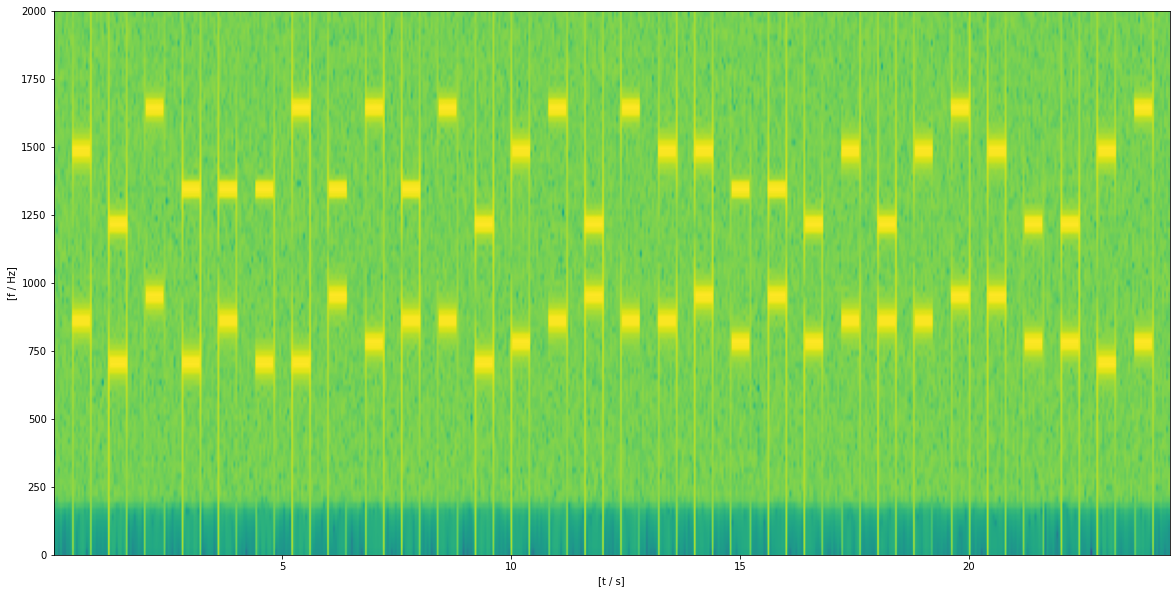

In [10]:
plt.figure(figsize=(20,10))
Pxx, freqs, bins, im = plt.specgram(dial_signal, NFFT=2048, Fs=samplerate)
plt.ylim(0,2000)
plt.xlabel("[t / s]")
plt.ylabel("[f / Hz]")
plt.show(im)

## Part 2: Filter Design <a class="anchor" id="part2"></a>
### Determining the Filter Coefficients of the Bandpass
In this example, we use a simple FIR filter design, to achieve bandpass behavior for particular frequencies (certainly, it is not a particuarly good filter design, but should work reasonably well in this case).
The filter coefficients of a filter with length $L$ can be found using the simple function

$$
b_k = \cos\bigg(2\pi\frac{f_b}{f_s}k\bigg),
$$

where $b_k$ is the $k$th filter coefficient, $k \in \{0,1,\ldots,L-1\}$, $f_b$ is the bandpass frequency and $f_s$ is the sample frequency. Equivalently, we can write:

$$
b_k = \cos\big(\hat{\omega}_b k\big),
$$

with $\hat{\omega}_b=2\pi\frac{f_b}{f_s}$.

The system function then is expressed as:

$$
\begin{align}
H(z) &=\sum_{k=0}^{L-1} \cos\big(\hat{\omega}_b k\big) z^{-k} && \\
&= \frac{1}{2} \sum_{k=0}^{L-1} z^{-k} e^{j \hat{\omega}_b k} &+& \frac{1}{2} \sum_{k=0}^{L-1} z^{-k} e^{-j \hat{\omega}_b k} \\
&= H_1(z) &+& H_2(z)
\end{align}
$$

To ensure that the magnitude of the frequency response $H(z)$ at $f_b$ is $1$, we have to find a scaling factor $\beta$ for the coefficients $b_k$. To do so, we need to evaluate the system function for $e^{j \hat\omega_b}$:

$$
\begin{align}
H_1\big( e^{j \hat\omega} \big) &= \frac{1}{2} \sum_{k=0}^{L-1} e^{-j \hat\omega k} e^{j \hat{\omega}_b k} = \frac{1}{2} \sum_{k=0}^{L-1} e^{j (\hat\omega_b-\hat\omega) k} \\
H_1\big( e^{j \hat\omega_b} \big) &= \frac{1}{2} \sum_{k=0}^{L-1} e^{j (\hat\omega_b-\hat\omega_b) k} = \frac{L}{2}
\end{align}
$$


$$
\begin{align}
H_2\big( e^{j \hat\omega} \big) &= \frac{1}{2} \sum_{k=0}^{L-1} e^{-j \hat\omega k} e^{-j \hat{\omega}_b k} = \frac{1}{2} \sum_{k=0}^{L-1} e^{-j (\hat\omega_b+\hat\omega) k} \\
H_2\big( e^{j \hat\omega_b} \big) &= \frac{1}{2} \sum_{k=0}^{L-1} e^{-j 2\hat\omega_b k} \\
&= \frac{1}{2} \frac{1-e^{-j 2\hat\omega_b L}}{1-e^{-j 2\hat\omega_b}} \\
&= \frac{1}{2} \frac{  e^{-j \hat\omega_b L} \Big(e^{j 2\hat\omega_b L}-e^{-j\hat\omega_b L} \Big)  }{ e^{-j\hat\omega_b} \Big(e^{j\hat\omega_b}-e^{-j\hat\omega_b}\Big) } \\
&= \frac{1}{2} \frac{\sin(\hat\omega_b L)}{\sin(\hat\omega_b)} e^{-j\hat\omega_b (L-1)} \\
&= \frac{1}{2} \frac{\sin(\hat\omega_b L)}{\sin(\hat\omega_b)} \bigg( \cos\big(\hat\omega_b (L-1)\big) - j\sin\big(\hat\omega_b (L-1)\big) \bigg)
\end{align}
$$

Overall, we get:

$$
\begin{align}
H\big( e^{j \hat\omega_b} \big) &= H_1\big( e^{j \hat\omega_b} \big) + H_2\big( e^{j \hat\omega_b} \big) \\
&= \frac{L}{2} + \frac{1}{2} \frac{\sin(\hat\omega_b L)}{\sin(\hat\omega_b)} \bigg( \cos\big(\hat\omega_b (L-1)\big) - j\sin\big(\hat\omega_b (L-1)\big) \bigg)
\end{align}
$$

To get the magnitude at $\hat\omega_b$ we first define:

$$
\begin{align}
\alpha &= \frac{1}{2} \frac{\sin(\hat\omega_b L)}{\sin(\hat\omega_b)} \\
Re\Big\lbrace H\big( e^{j \hat\omega_b} \big) \Big\rbrace &= \frac{L}{2} + \alpha \cos\big(\hat\omega_b (L-1)\big) \\
Im\Big\lbrace H\big( e^{j \hat\omega_b} \big) \Big\rbrace &= -\alpha \sin\big(\hat\omega_b (L-1)\big)
\end{align}
$$

and then compute:

$$
\beta = \Big| H\big( e^{j \hat\omega_b} \big) \Big| = \sqrt{ Re\Big\lbrace H\big( e^{j \hat\omega_b} \big) \Big\rbrace^2 +  Im\Big\lbrace H\big( e^{j \hat\omega_b} \big) \Big\rbrace^2  }
$$

Finally, let us scale the filter weights accordingly, to have a maximum magnitude of $1$ at $f_b$:

$$
b_k = \frac{1}{\beta}\cos\big(\hat{\omega}_b k\big),
$$

A Python3 function to compute the weights of a specified realization of the bandpass filter is defined below (although Python3 can handle complex numbers, we separate imaginary and real part of the complex numbers, to have it easier later when implementing the C equivalent of this function):

In [11]:
def filter_coeff(f_b, f_s, filter_len):
    L = filter_len
    w0 = 2*math.pi * f_b / f_s

    beta_2_A = 1/2.0*math.sin(w0*L) / math.sin(w0)
    beta_real = L/2 + beta_2_A * math.cos( w0 * (L-1) )
    beta_imag = -beta_2_A * math.sin( w0 * (L-1) )
    beta = math.sqrt(beta_real*beta_real + beta_imag*beta_imag)
    
    k = np.arange(L)
    hh = 1.0/beta * np.cos(w0*k)
    return hh

### Plot the Frequency Response of a selected Bandpass Filter

In [13]:
freqz = np.array([1209, 1336, 1477, 1633, 697, 770, 852, 941])
freqz = np.sort(freqz)
print("DTMF Frequencies:", freqz)

DTMF Frequencies: [ 697  770  852  941 1209 1336 1477 1633]


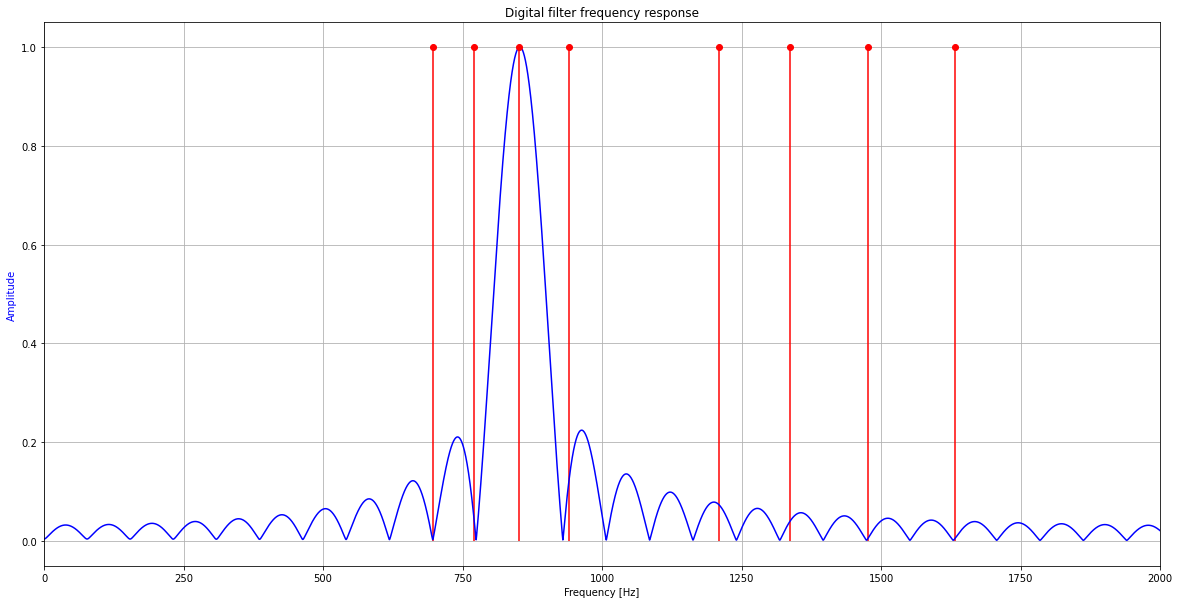

In [14]:
L = 71
f_b = freqz[2] # Select the frequency 852 Hz for the bandpass filter
f_s = samplerate/8

hh = filter_coeff(f_b, f_s, L)

w, H = signal.freqz(hh, worN=1024*32)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
plt.title('Digital filter frequency response')

plt.plot(w*f_s/(2*np.pi), abs(H), 'b')
plt.ylabel('Amplitude', color='b')
plt.xlabel('Frequency [Hz]')


plt.stem(freqz, np.ones_like(freqz), 'r', 'or', basefmt=" ")

plt.xlim(0,2000)
plt.grid()
plt.show()

### Determine the optimal Filter Length for a given Range
Generally, longer filters have a "sharper" frequency response and are better suited to remove the "undesired" frequencies. However, longer filters also require more computation effort. Additionally, due to the position of the zeros of the frequency response, there might exist filter lengths that are smaller than others, but have a "better" location of the zeros and, hence, are more effective in removing the remaining 7 other frequencies, which might be present in the signal. The following code attempts to find an optimal filter length in the interval [10,100]. As it turns out, a length of $71$ appears to be optimal for the filter design that we selected:

In [15]:
# For a particular frequency, iterate through different filter lengths and try to minimize the response for the remaining frequencies
f_s = samplerate/8
ww = 2*math.pi * freqz / f_s
best_L, best_err = None, math.inf
LL = []
ee = []
for L in range(10,100):
    errs = 0
    for f in freqz:
        hh = filter_coeff(f, f_s, L)
        w, H = signal.freqz(hh, worN=ww)
        #plt.stem(ww,abs(H), 'r', 'or', basefmt=" ")
        errs += sum(abs(H))
    if errs < best_err:
        best_L, best_err = L, errs
        
    LL.append(L)
    ee.append(errs)
    
print("Best L =", best_L)

Best L = 71


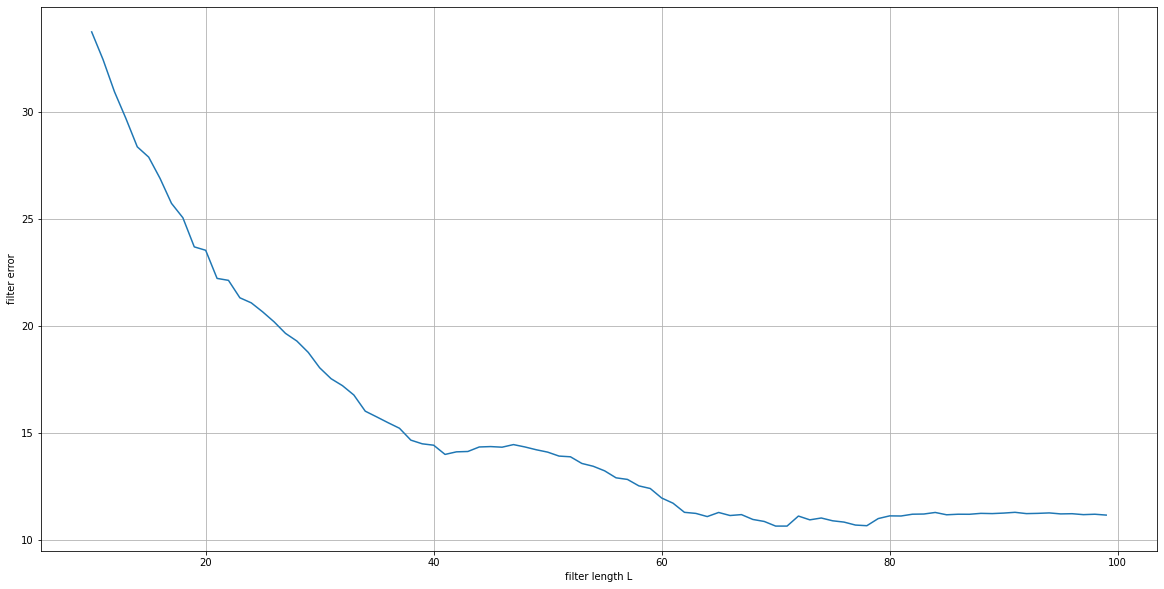

In [16]:
plt.figure(figsize=(20,10))
plt.plot(LL, ee)
plt.xlabel("filter length L")
plt.ylabel("filter error")
plt.grid()

## Part 3: Determine the dialed Sequence for a given WAV Audio File <a class="anchor" id="part3"></a>
### Filter the Signal using the individual FIR filter

In [17]:
wav_file_name = "wav/my_dtmf_file.wav" # change accordingly, if you wish to analyze another DTMF signal file
decimateFac = 8

In [18]:
samplerate, data = wavfile.read(wav_file_name)
print(f"data.shape = {data.shape}")
length = data.shape[0] / samplerate
print(f"length = {length}s")

data.shape = (1076040,)
length = 24.4s


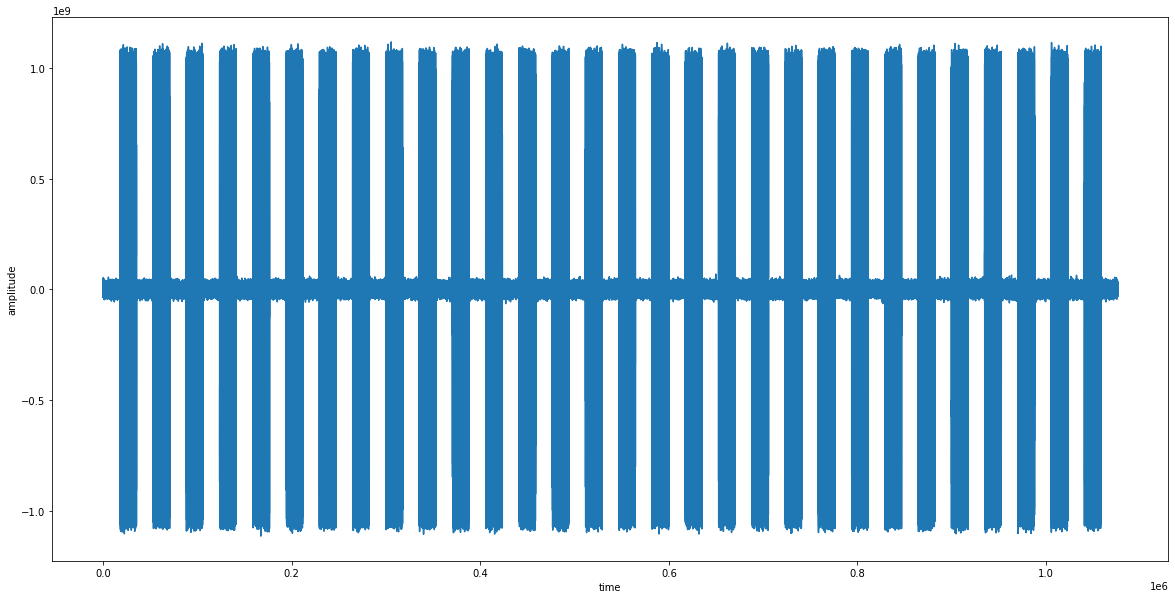

In [19]:
# Plot the data in time domain. The individual subsequences, representing the dialed numbers, should become apparent
plt.figure(figsize=(20,10))
plt.plot(data)
plt.xlabel("time")
plt.ylabel("amplitude")
plt.show()

In [20]:
# For debugging purposes only:
def convolve(x, hh):
    L = len(hh)
    xx = np.zeros_like(x, dtype=np.float32)
    for i in range(len(x) - L + 1):
        for j in range(L):
            xx[i] += hh[j] * x[i+L-1-j]
    return xx[:-L+1]

In [21]:
wavSignal = data[::decimateFac] / 2147483647.0 # decimate and divide by max. int32 value
wavSignal = wavSignal.astype('float32')
sq_wavSignal_mean = np.mean(wavSignal**2)
f_s = samplerate/decimateFac # also the sample rate changed due to the decimation step
L = best_L
all_filtered_signals = []
for f_b in freqz:
    hh = filter_coeff(f_b, f_s, L)
    signal_filtered = np.convolve(wavSignal, hh, mode='valid').astype("float32")
    if False:
        plt.figure()
        plt.plot(signal_filtered**2)
    ss = signal_filtered**2 
    # compute the signal power of the filtered signal in a sliding window
    ss = np.convolve(ss, np.ones(100)/100.0, mode='valid') 
    ss = (ss > .5*sq_wavSignal_mean)
    
    all_filtered_signals.append(ss * f_b)
    
    if False:
        plt.figure(figsize=(9,6))
        Pxx, freqs, bins, im = plt.specgram(signal_filtered, NFFT=2048, Fs=f_s)
        plt.ylim(0,2000)
        plt.xlabel("[t / s]")
        plt.ylabel("[f / Hz]")
        plt.show(im)

In [22]:
## Check if np.convolve behaves as expected...
# np.convolve(signal, hh, 'valid') - convolve(signal, hh)

In [23]:
all_filtered_signals = np.stack(all_filtered_signals)
sel = np.argsort(all_filtered_signals, axis=0)
top2 = []
for c_idx in range(sel.shape[-1]):
    col = sel[:,c_idx]
    v1, v2 = all_filtered_signals[col[-2], c_idx], all_filtered_signals[col[-1], c_idx]
    top2.append([v1, v2])

In [24]:
top2 = np.array(top2).T
mask = (top2[0] < 500) | (top2[1] < 500)
top2[:,mask] = 0.0 # delete values, where not two frequencies are present

In [25]:
# downsample the sequence of frequencies
for i in range(6):
    new_arr = []
    for c in range(1,top2.shape[-1]//2):
        v1, v2 = max(top2[0,2*c-1],top2[0,2*c]), max(top2[1,2*c-1],top2[1,2*c])
        new_arr.append([v1,v2])
    top2 = np.array(new_arr).T

In [26]:
# run-length encoding of sufficiently shortened signal
from itertools import groupby

l_f = []
for k,i in groupby(top2[0].tolist()):
    l_f.append(k)
h_f = []
for k,i in groupby(top2[1].tolist()):
    h_f.append(k)
    
freqz_pairs = list(zip(l_f,h_f))

In [27]:
matrix = np.array(['1', '2', '3', 'A', '4', '5', '6', 'B', '7', '8', '9', 'C', '*', '0', '#', 'D']).reshape(4,4)
freqz_cols = [1209, 1336, 1477, 1633]
freqz_rows = [697, 770, 852, 941]
df = pd.DataFrame(matrix, index=pd.Index(freqz_rows), columns=freqz_cols)
print(df)

    1209 1336 1477 1633
697    1    2    3    A
770    4    5    6    B
852    7    8    9    C
941    *    0    #    D


In [28]:
# Finally, we obtain the dialed sequence
sequence = ""
for p in freqz_pairs:
    if p[0] > 0 and p[1] > 0:
        sequence += str(df.loc[ (p[0], p[1]) ])
print("dialed sequence:", sequence)

dialed sequence: 91D282A0B8C16C*C9#504979D#443B


In [29]:
# Is the obtained sequence the same as the one that we generated in the beginning?
print("Is the obtained sequence the same as the one that we generated in the beginning?", sequence == my_dialed_sequence)

Is the obtained sequence the same as the one that we generated in the beginning? True


## Part 4: Determine the dialed Sequence for a given WAV Audio File (CUDA/C/C++) <a class="anchor" id="part4"></a>
The algorithm illustrated in the previous section was implemented in Python 3. Here, we use the same methodology as in the previous section, but implement the whole functionaility in C++ using CUDA.


### Compiling the Source Code using CMake

```
cd DTMFCuda/
mkdir build && cd build
cmake .. # Process the CMakeLists.txt
cmake --build . # Build the executable
./dtmfCUDA # Run the program
``` 

### Compiling the Source Code using the Makefile

```
cd DTMFCuda/
make build
make run
make clean # remove the build directory to clean up
```

### Compiling the Source Code directly using nvcc

```
cd DTMFCuda/
mkdir build && cd build
nvcc -I.. -I/usr/local/cuda/include -I/usr/local/cuda/lib64 -lcudart -lcuda --std c++17 ../dtmfCuda.cu -o dtmfCUDA
./dtmfCUDA # Run the program
```

## Miscellaneous <a class="anchor" id="misc"></a>
### Converting this Jupyter Notebook to Markdown
```
jupyter nbconvert dtmf_example.ipynb --to markdown --ExtractOutputPreprocessor.enabled=True --NbConvertApp.output_files_dir="img"
```